# SECOM Dataset Analysis

In this project, the goal will be to predict failureS in the manufacturing process from the SECOM dataset. The main challanges with this project include the high dimensionality, large amount of missing data and importantly the imbalanced nature of the target variable. 

The major issues I have seen people encounter (and myself) is type one errors (possitive prediction being a manufacutring failure). 

In [1]:
# import required packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import RFE, RFECV, chi2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import *
from sklearn.tree import plot_tree
from scipy.stats import zscore
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
import keras
import kerastuner as kt
from keras import models, optimizers
from keras.layers import *
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [2]:
# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

### Preparing Data

In [3]:
# read in data
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data', sep=' ', header=None)

# read in labels and timestamps
labels = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data',
                     sep=' ', header=None, names=['Class', 'Timestamp'])

Now that we have read in our data and labels, the first thing we should do is join these two dataframes together. Our dataset contains 590 different features which are each different sensors from the manufacturing process. The distribution of each sensor varies widly and should be normalized going forward. The target variable is the 'Class' feature consisting of values -1 (pass) and 1 (fail). I will change the -1 value to 0. Importanatly, if you leave the class values as -1 and 1, then the loss function for the neural network should be 'hinge'

In [4]:
# concatenate the dataframes
df = pd.concat([data, labels], axis=1)

# replace Class value of -1 with 0
df['Class'].replace(-1, 0, inplace=True)

# drop Timestamp column
df.drop('Timestamp', axis=1, inplace=True)

# look at head of dataframe
df.head()

,0,1,2,3,4,5,6,7,8,9,...,581,582,583,584,585,586,587,588,589,Class
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [5]:
# Remove columns with many missing values
df = df[df.columns[df.isna().sum() <= 260]]

In [6]:
# Drop several rows with large number of missing values
df.drop([1566, 1564, 1561, 995, 1152, 1054], axis=0, inplace=True)

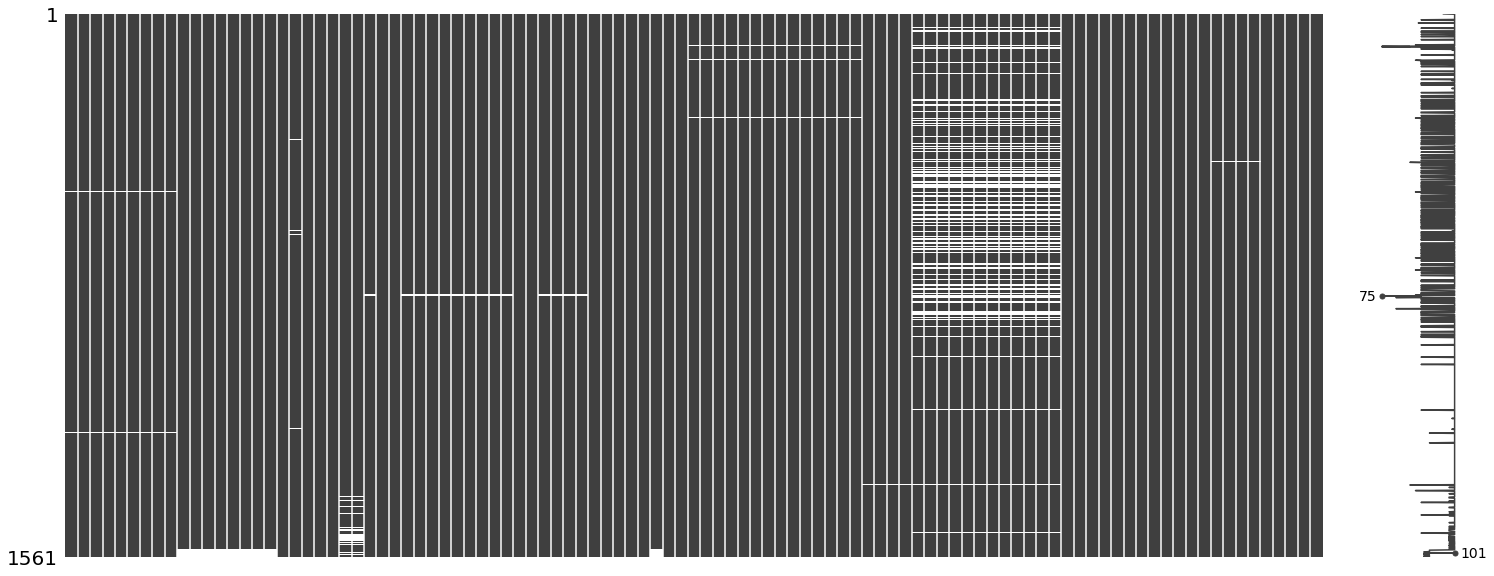

In [7]:
# visual inspection of remaining missing values
msno.matrix(df.iloc[:, 450:])

### Imputation
NaN values will be replaced with median. I previously attemped to use the iterative imputer packge through sklearn which can be very powerful, but depending on the amount of missing data can take extremely long. That was the case with this dataset, and I found little improvement in model predictive power so I returned to median replacement.

In [8]:
# replace nan with median
df.fillna(df.median(), inplace=True)

### Outliers
Below I have ploted sensor 156, which is a good example of a feature with extreme outliers. These outliers are most likely caused by sensor errors. It could be possible that are some kind of alarm values and are actually important, but with no way to be sure, I believe it is safer to replace them with the median value. 

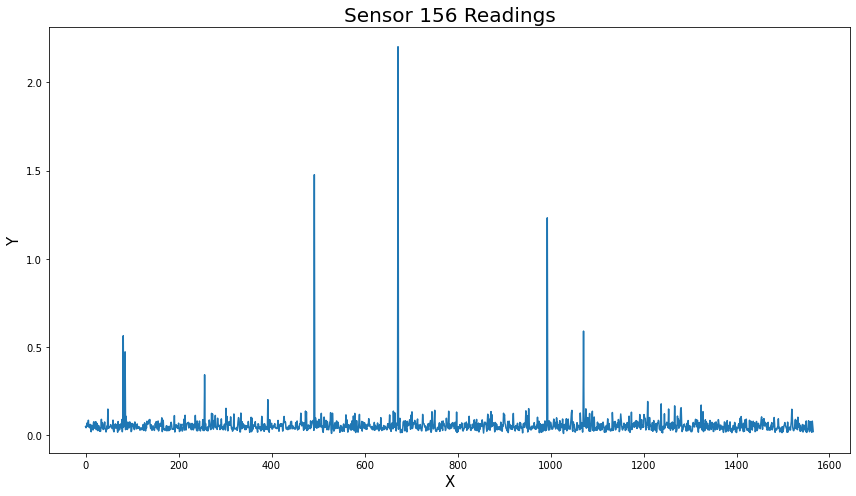

In [9]:
# plot sensor
f, axes = plt.subplots(figsize=(12, 7))
sns.lineplot(x=df.index, y=156, data=df)
plt.title('Sensor 156 Readings', fontsize=20)
axes.set_xlabel('X', size=15)
axes.set_ylabel('Y', size=15)
plt.tight_layout()
plt.show()

In [10]:
# replace outliers with median
for i in df.drop('Class', axis=1).columns:
    median = df.loc[np.abs(zscore(df[i])) < 3, i].median()
    df.loc[np.abs(zscore(df[i])) > 3, i] = median

C:\Users\Chris\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
<ipython-input-10-8ee43aa4883b>:3: RuntimeWarning: invalid value encountered in less
  median = df.loc[np.abs(zscore(df[i])) < 3, i].median()
<ipython-input-10-8ee43aa4883b>:4: RuntimeWarning: invalid value encountered in greater
  df.loc[np.abs(zscore(df[i])) > 3, i] = median


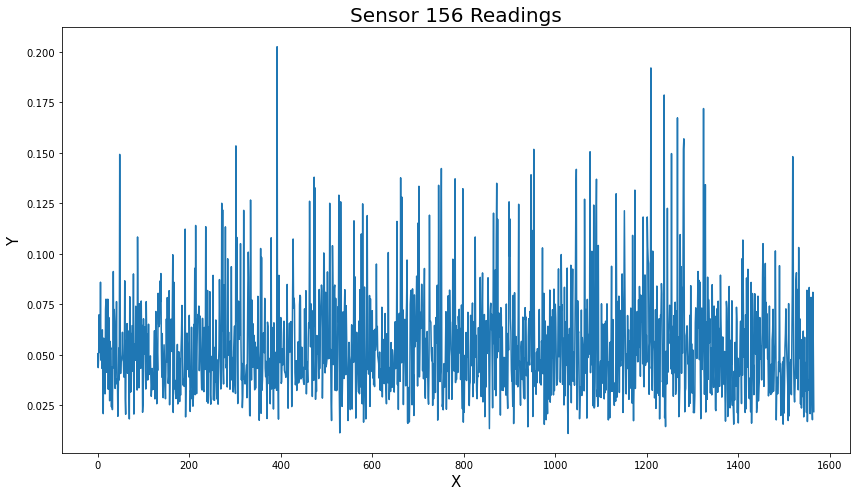

In [11]:
# plot sensor
f, axes = plt.subplots(figsize = (12, 7))
sns.lineplot(x=df.index, y=156, data=df)
plt.title('Sensor 156 Readings', fontsize=20)
axes.set_xlabel('X',size=15)
axes.set_ylabel('Y',size=15)
plt.tight_layout()
plt.show()

### Data Normalizing 

In [12]:
# normalize data 
target = df['Class']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled['Class'] = target

### Feature Selection

In [13]:
# remove constant value columns
const_cols = df_scaled.columns.values[df_scaled.describe().iloc[2] == 0]
df_scaled.drop(const_cols, axis=1, inplace=True)

In [14]:
# fit random forest
rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(df_scaled.drop('Class', axis=1), df_scaled['Class'])

# sorting features according to their rank
importance = rf.feature_importances_
dic = {'importance': importance, 'columns': df_scaled.columns[:-1]}
ranked_columns = pd.DataFrame(dic).sort_values('importance', ascending=False)[:40]['columns'].values

In [15]:
# top 40 most important features - randomforestclassifier determined
df_reduced = pd.concat([df_scaled[ranked_columns], df_scaled['Class']], axis=1)

### Modeling
I tried many different resampling strategies and most performed similarly. I found that it was important that the ratio of pass to failures between training and testing sets was kept the same. Because of this SMOTE was not as useful due to the fact you must only resample the training set. 

In [16]:
# resample data
def resample(data, resample_type=None, sampling_ratio=None):
    
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1],
                                                    test_size=0.2, random_state=2, stratify=data.iloc[:,-1])
    
    smote = SMOTE(sampling_strategy=sampling_ratio, random_state=42)
    rand_under = RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)
    near_miss = NearMiss(version=3, n_neighbors_ver3=3)
    cnn = CondensedNearestNeighbour(sampling_strategy='not minority')
    
    if resample_type == 'smote':
        X_train, y_train = smote.fit_sample(X_train, y_train)
    elif resample_type == 'rand_under':
        X_train, y_train = rand_under.fit_sample(X_train, y_train)
    elif resample_type == 'near_miss':
        X_train, y_train = near_miss.fit_sample(X_train, y_train)    
    elif resample_type == 'cnn':
        X_train, y_train = cnn.fit_sample(X_train, y_train)
    
    return(X_train, X_test, y_train, y_test)

In [17]:
# split data
X_train, X_test, y_train, y_test = resample(df_reduced, 'rand_under', sampling_ratio=0.3)

print(y_train.value_counts())
print(y_test.value_counts())

0    276
1     83
Name: Class, dtype: int64
0    292
1     21
Name: Class, dtype: int64


### Decision Tree Classification

In [18]:
gs = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={'criterion': ['gini', 'entropy'],
                    'max_depth': [6, 8, 10],
                    'max_leaf_nodes': [9, 10, 11],
                    'min_samples_leaf': [2, 3, 4, 5],
                    'min_samples_split': [1, 2, 3, 4, 5]},
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gs.fit(X_train, y_train)
best_params = grid_result.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 8,
 'max_leaf_nodes': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 3}

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       292
           1       0.33      0.38      0.36        21

    accuracy                           0.91       313
   macro avg       0.64      0.66      0.65       313
weighted avg       0.91      0.91      0.91       313

Matthews Coefficient:  0.3066721799460071


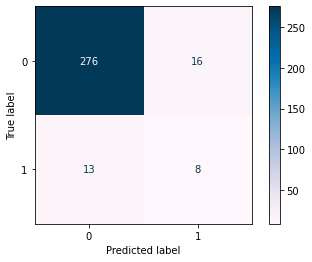

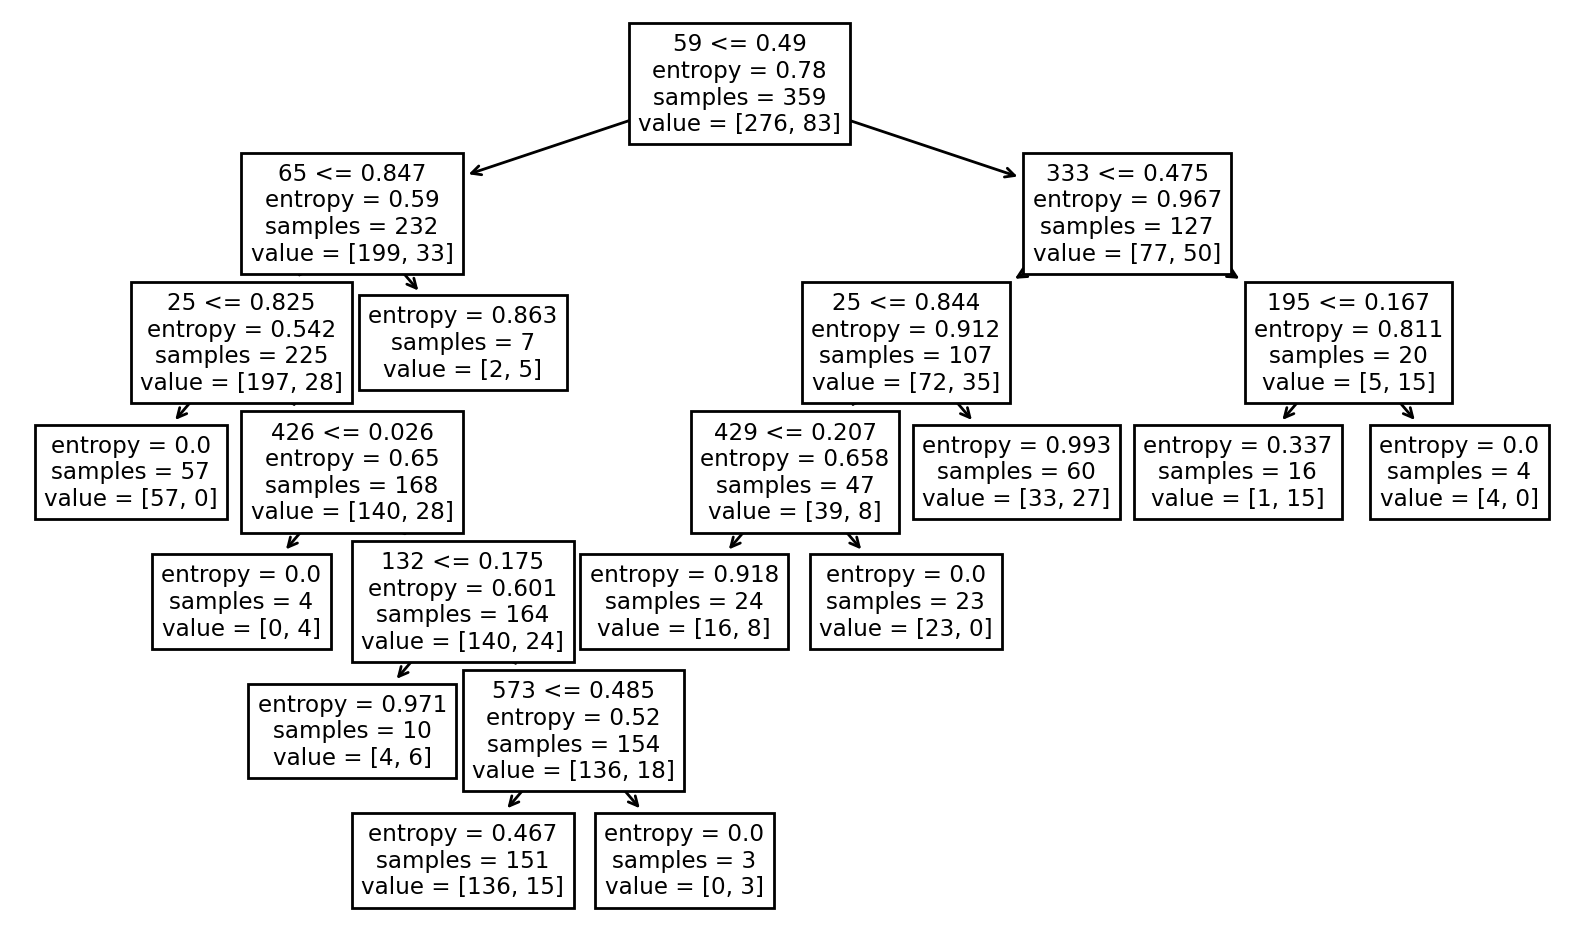

In [19]:
tree_model = DecisionTreeClassifier(**best_params, random_state=1).fit(X_train, y_train)

# predict values
tree_predicted = tree_model.predict(X_test)

# find performance of model
print('Performance Metrics: \n{}'.format(classification_report(y_test, tree_predicted)))
print('Matthews Coefficient: ', matthews_corrcoef(y_test, tree_predicted, ))
plot_confusion_matrix(tree_model, X_test, y_test, cmap='PuBu')
plt.show()

# produce decision tree figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=200)
plot_tree(tree_model, feature_names=df_reduced.columns[:-1]);

### Ensemble Model

Performance Metrics: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       292
           1       0.50      0.43      0.46        21

    accuracy                           0.93       313
   macro avg       0.73      0.70      0.71       313
weighted avg       0.93      0.93      0.93       313

Matthews Coefficient:  0.427


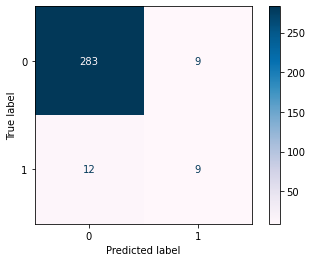

In [20]:
# fit to xgb classifier
xgb_model = XGBClassifier(gamma=0.5).fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
# find accuracy of predictions
print('Performance Metrics: \n{}'.format(classification_report(y_test, y_pred)))
print('Matthews Coefficient: ', matthews_corrcoef(y_test, y_pred).round(3))
plot_confusion_matrix(xgb_model, X_test, y_test, cmap='PuBu')
plt.show()

### SVM Model

Performance Metrics:  
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       292
           1       0.44      0.33      0.38        21

    accuracy                           0.93       313
   macro avg       0.70      0.65      0.67       313
weighted avg       0.92      0.93      0.92       313

Matthews Coefficient:  0.427


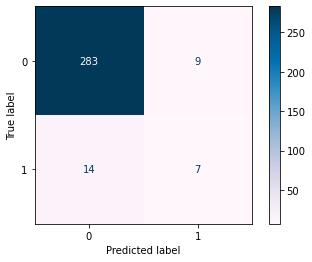

In [21]:
# fit model with parameters found from grid search
svc_model = svm.SVC(C=10, kernel='linear', random_state=42).fit(X_train, y_train)

# predict values
svc_predicted = svc_model.predict(X_test)
# see performance metrics
print('Performance Metrics: ', '\n', classification_report(y_test, svc_predicted))
print('Matthews Coefficient: ', matthews_corrcoef(y_test, y_pred).round(3))
plot_confusion_matrix(svc_model, X_test, y_test, cmap='PuBu')
plt.show()

Performance Metrics:  
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       292
           1       0.36      0.38      0.37        21

    accuracy                           0.91       313
   macro avg       0.66      0.67      0.66       313
weighted avg       0.92      0.91      0.91       313

Matthews Coefficient:  0.326


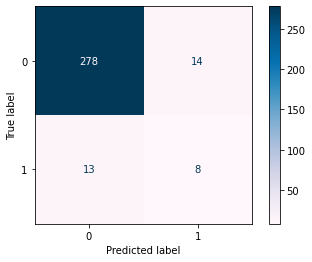

In [22]:
log_model = LogisticRegression(C=10, random_state=1)
log_model.fit(X_train, y_train) 
y_pred = log_model.predict(X_test)

# see performance metrics
print('Performance Metrics: ', '\n', classification_report(y_test, y_pred))
print('Matthews Coefficient: ', matthews_corrcoef(y_test, y_pred).round(3))
plot_confusion_matrix(log_model, X_test, y_test, cmap='PuBu')
plt.show()

Performance Metrics:  
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       292
           1       1.00      0.14      0.25        21

    accuracy                           0.94       313
   macro avg       0.97      0.57      0.61       313
weighted avg       0.95      0.94      0.92       313

Matthews Coefficient:  0.367


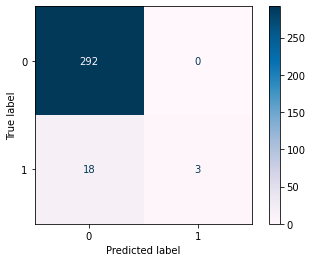

In [23]:
rf_model = RandomForestClassifier(criterion='entropy', min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train) 
y_pred = rf_model.predict(X_test)

# see performance metrics
print('Performance Metrics: ', '\n', classification_report(y_test, y_pred))
print('Matthews Coefficient: ', matthews_corrcoef(y_test, y_pred).round(3))
plot_confusion_matrix(rf_model, X_test, y_test, cmap='PuBu')
plt.show()

The random forest model is the only one that was able to not produce any type one errors (false positive). At the same time the RF model only correctly classified 3 of 21 failures while the SVM model correctly predicted 9. 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_reduced.iloc[:, :-1], df_reduced.iloc[:, -1], random_state=42)

In [25]:
# undersampling, classification and computing ROC values

fpr = dict()
tpr = dict()
roc_auc = dict()

ratio = [0.3, 0.4, 0.5, 0.6, 0.7]
    
estimators = [('rus', RandomUnderSampler(random_state=42)), 
              ('clf', RandomForestClassifier(criterion='entropy', min_samples_split=5, random_state=42))]

pipe = Pipeline(estimators)

print(pipe)

for i, ratio in zip(range(5), ratio):
    pipe.set_params(rus__sampling_strategy = ratio)
    probas_ = pipe.fit(X_train, y_train).predict_proba(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_test, probas_[:,1])
    roc_auc[i] = auc(fpr[i], tpr[i])

Pipeline(steps=[('rus', RandomUnderSampler(random_state=42)),
                ('clf',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=5,
                                        random_state=42))])


In [26]:
def plot_roc(fpr, tpr, roc_auc):
    
    ratios = [0.3, 0.4, 0.5, 0.6, 0.7]

    plt.figure(figsize=(14, 12))
    for i, ratio in zip(range(5), ratios):
        plt.plot(fpr[i], tpr[i], lw=2, linestyle='--',
                 label='{0} (area = {1:0.2f})'
                 ''.format(ratio, roc_auc[i]))

    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves: Random Undersampling of Majority class', fontsize=14)
    plt.legend(title='Class ratio after undersampling', loc="lower right")
    plt.show()

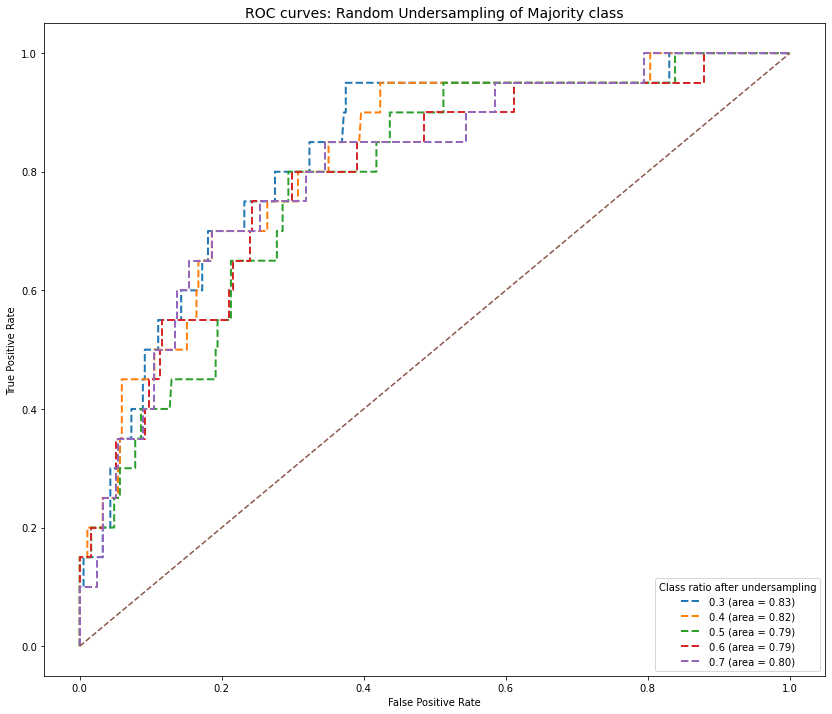

In [27]:
plot_roc(fpr, tpr, roc_auc)

### Basic Neural Network Modeling

In [28]:
def resample_and_split(data, resample_type=None, sampling_ratio=None):
    
    X_train, X_test, y_train, y_test = resample(data=data, resample_type=resample_type, sampling_ratio=sampling_ratio)

    # shuffle train data
    train_set = shuffle(pd.concat([X_train, y_train], axis=1))
    X_train = train_set.drop('Class', axis=1)
    y_train = train_set['Class']

    # shuffle test data
    test_set = shuffle(pd.concat([X_test, y_test], axis=1))
    X_test = test_set.drop('Class', axis=1)
    y_test = test_set['Class']

    # format data for tensorflow
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = tf.keras.utils.to_categorical(y_train, 2)
    y_test = tf.keras.utils.to_categorical(y_test, 2)
    return X_train, X_test, y_train, y_test

In [29]:
# resample and split data for each feature selection method
X_train, X_test, y_train, y_test = resample_and_split(df_reduced, 'rand_under', 0.3)

### Grid Searching 

In [30]:
from kerastuner import HyperModel
class RegressionHyperModel(HyperModel):

    def __init__(self):
        self.input_shape = (40,)
        
    def build(self, hp):
        model =  tf.keras.models.Sequential()
        
        model.add(
            Dense(
                units=hp.Int('units', 10, 50, step=5, default=10),
                activation=hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
                input_shape=self.input_shape))
        
        model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.3,
                    default=0.0,
                    step=0.02)))
        
        for i in range(hp.Int('n_layers', 1, 2)):
            model.add(
                Dense(
                    units=hp.Int('units', 10, 50, step=5, default=10),
                    activation=hp.Choice(
                        'dense_activation',
                        values=['relu', 'tanh', 'sigmoid'],
                        default='relu')))
            
            model.add(
            Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.3,
                    default=0.0,
                    step=0.02)))
        
        model.add(Dense(2))
        
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss='binary_crossentropy', 
            metrics=['accuracy'])
        
        return model

In [31]:
hypermodel = RegressionHyperModel()

tuner_rs = kt.RandomSearch(
            hypermodel,
            objective='loss',
            seed=42,
            max_trials=20,
            executions_per_trial=2,
            directory='C:/.....')

tuner_rs.search(X_train, 
                y_train, 
                epochs=15,
                batch_size=12,
                validation_data=(X_test, y_test), 
                verbose=0)

INFO:tensorflow:Reloading Oracle from existing project C:/Users/Chris/Google Drive/Programming/Portfolio Projects\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from C:/Users/Chris/Google Drive/Programming/Portfolio Projects\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [38]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)

10/10 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.96 - 0s 500us/step - loss: 0.3852 - accuracy: 0.9297


In [39]:
tuner_rs.get_best_hyperparameters()[0].values

{'units': 40, 'dense_activation': 'relu', 'dropout': 0.04, 'n_layers': 1}

In [41]:
model = tf.keras.models.Sequential()
model.add(Dense(40, input_shape=(40,), activation='relu'))
model.add(Dense(2, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.05)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit to training model
model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=50,
          verbose=0)

# predict 
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)

# print scoring metrics
print('Performance Metrics: ', '\n', classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)), index=[0, 1], columns=[0, 1]))

Performance Metrics:  
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       292
           1       0.21      0.33      0.25        21

    accuracy                           0.87       313
   macro avg       0.58      0.62      0.59       313
weighted avg       0.90      0.87      0.88       313

     0   1
0  265  27
1   14   7


While working with this dataset I have found that feature selection and imbalanced classes are the two main issues. In previous iterations of this notebook I have tried numerous feature selection methods and using feature importances produced through a random forest classification has worked the best. However, it does not work as well when producing a neural network model. Importantly for the class imbalance problem, SMOTE does not work as well as random undersampling. 

Looking at research papers on this dataset has convinced me that feature selection may be the key to producing a well working model. Others have achieved very good results using a neural network will almost 100 percent failed class prediction. Unfortunately they did not go into detail about their methodology enough for me to get any value from it.